# Seminar 1

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch utils https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Logisticpdfunction.svg/900px-Logisticpdfunction.svg.png
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Logistic_cdf.svg/2560px-Logistic_cdf.svg.png
!mv 2560px-Logistic_cdf.svg.png logistic_cdf.png
!mv 900px-Logisticpdfunction.svg.png logistic_pdf.png

In [3]:
from dul_2021.utils.pr1_utils import *

In [4]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F

from PIL import Image
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# Example 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


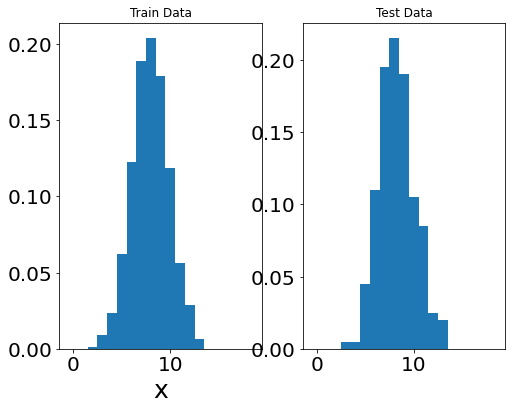

Dataset 2


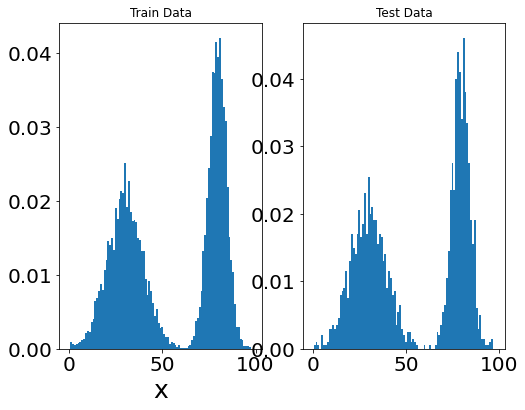

In [10]:
visualize_pr1_data(dset_type=1)
visualize_pr1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**We will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution


In [11]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    
    def nll(self, batch):
        raise NotImplementedError()
    
    def probs(self):
        raise NotImplementedError()

    def test(self, data_loader):
        loss = 0
        den = 0
        for batch in data_loader:
            batch.to(device)
            batch_loss = self.nll(batch) * batch.shape[0]
            loss += batch_loss.cpu().detach().item()
            den += batch.shape[0]

        return loss / den

    def fit(self,
            train_data,
            test_data,
            num_epochs=10,
            batch_size=32,
            lr=1e-3):
        
        train_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size,
                                                   shuffle=True)
        
        test_loader = torch.utils.data.DataLoader(train_data, 
                                                  batch_size=batch_size)
        
        optim = opt.Adam(self.parameters(), lr)
        train_nll = []
        test_nll = []


        self.to(device)
        for epoch in range(num_epochs):
            for batch in train_loader:
                batch = batch.to(device)

                loss = self.nll(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                train_nll.append(loss.detach().cpu().item())
            
            test_loss = self.test(test_loader)
            test_nll.append(test_loss)

        return train_nll, test_nll

In [12]:
class HistogramA(Histogram):
    def __init__(self, d):
        super().__init__(d)
        self.theta = nn.Parameter(torch.zeros(1, d), requires_grad=True)
    
    def nll(self, batch):
        return F.cross_entropy(self.theta.repeat(batch.shape[0], 1), batch)
    
    def probs(self):
        return F.softmax(self.theta.squeeze(), dim=0).cpu().detach().numpy()

$CrossEntropy(x, y) = -LogLikelihood(SoftMax(x), y) = \frac 1 {n}\sum\limits_{i=1}^{n} -\left(\log e^{x_{y_i}} - \log \sum e^{x_j}\right)$

In [13]:
def pr1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    model = HistogramA(d)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-1, batch_size=100)
    probs = model.probs()
    return train_loss, test_loss, probs


### Results



Final Test Loss: 2.0695


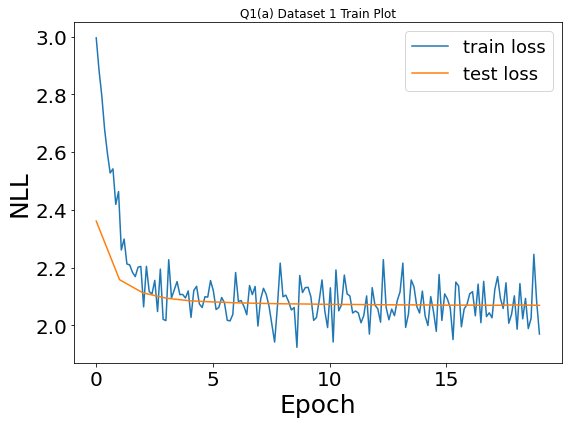

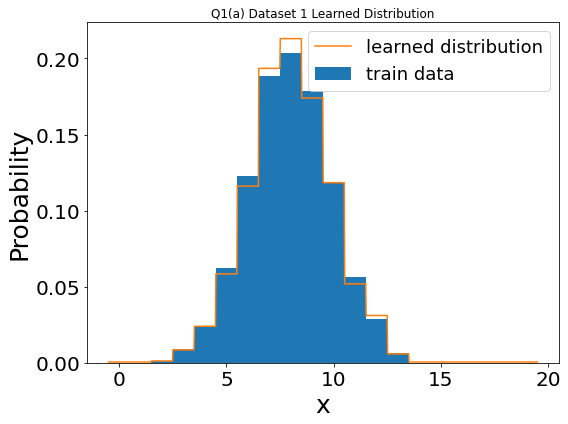

In [15]:
pr1_save_results(1, 'a', pr1_a)

Final Test Loss: 4.0517


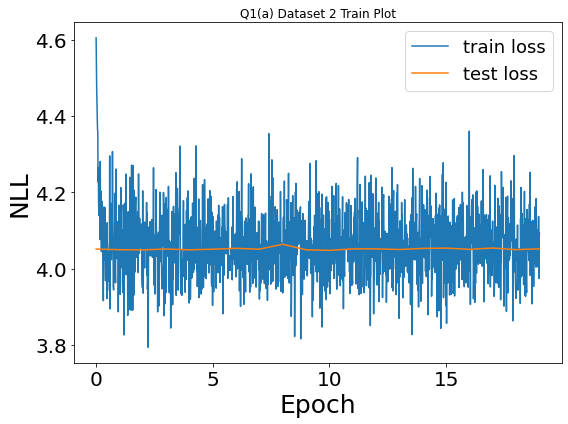

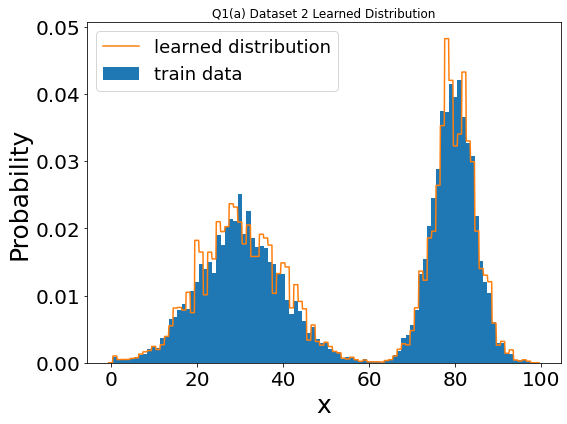

In [16]:
pr1_save_results(2, 'a', pr1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.


In [17]:
logistic_pdf = Image.open('logistic_pdf.png')
logistic_cdf = Image.open('logistic_cdf.png')

In [18]:
im1 = logistic_pdf.resize((600, 500))
im2 = logistic_cdf.resize((600, 500))

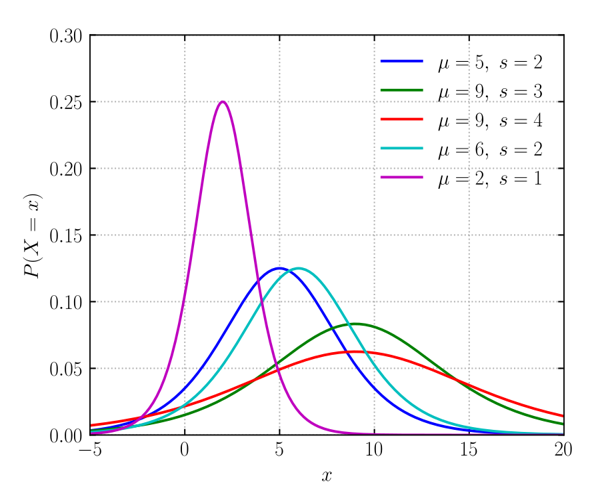

In [19]:
im1

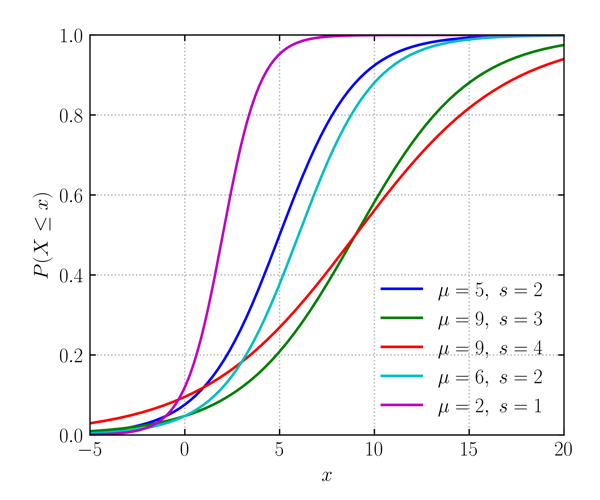

In [20]:
im2

### Solution

In [21]:
class HistogramB(Histogram):
    def __init__(self, d, k=4):
        super().__init__(d)
        self.pi_logits = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.mu = nn.Parameter(torch.rand(k).float() * d, requires_grad=True)
        self.log_s = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.k = k

    def nll(self, batch, loss=True):
        x = batch.float().unsqueeze(1).repeat(1, self.k)

        pos = torch.sigmoid((x + 0.5 - self.mu) / self.log_s.exp())
        neg = torch.sigmoid((x - 0.5 - self.mu) / self.log_s.exp())


        pos = torch.where(x == self.d - 1, torch.ones_like(pos), pos)
        neg = torch.where(x == 0, torch.zeros_like(neg), neg)
        
        dif = pos - neg
        dif = torch.clamp(dif, min=1e-16)
        log_dif = dif.log()
        log_prob = log_dif + F.log_softmax(self.pi_logits, dim=0)

        if loss:
            ret = -torch.logsumexp(log_prob, dim=1).mean()
        else:
            ret = log_prob
        
        return ret
    
    def single_prob(self, i):
        x = torch.arange(self.d)
        probs = self.nll(x, loss=False)
        probs = probs[:, i]
        return probs.exp().cpu().detach().numpy()

    def probs(self):
        x = torch.arange(self.d)
        probs = self.nll(x, loss=False)
        probs = torch.logsumexp(probs, dim=1)
        return probs.exp().cpu().detach().numpy()

In [22]:
def pr1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    model = HistogramB(d, k=4)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=30, lr=1e-1, batch_size=100)
    probs = model.probs()
    return train_loss, test_loss, probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0704


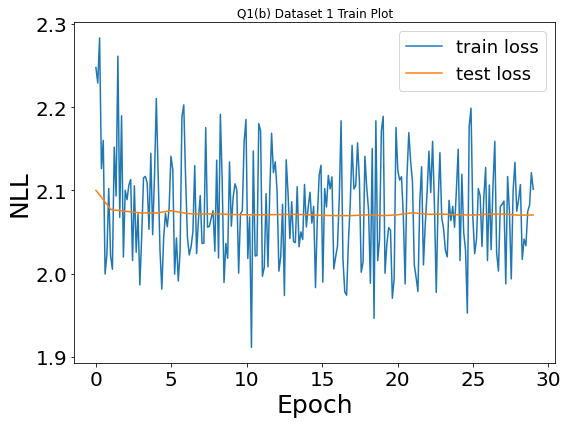

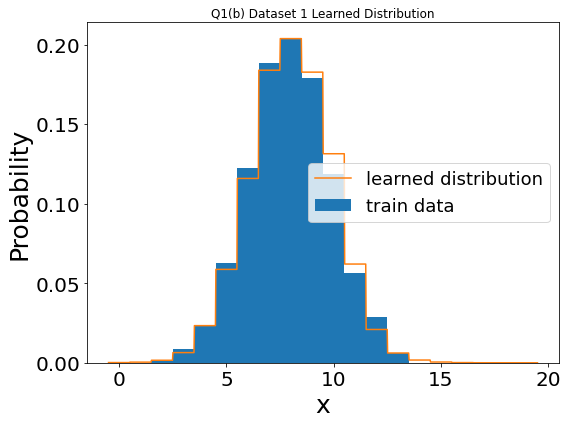

In [23]:
pr1_save_results(1, 'b', pr1_b)

Final Test Loss: 4.0592


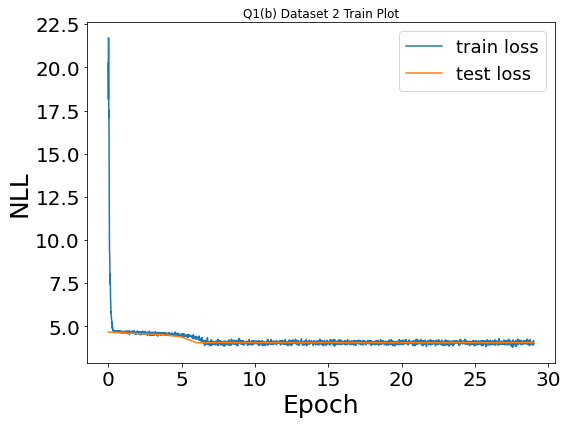

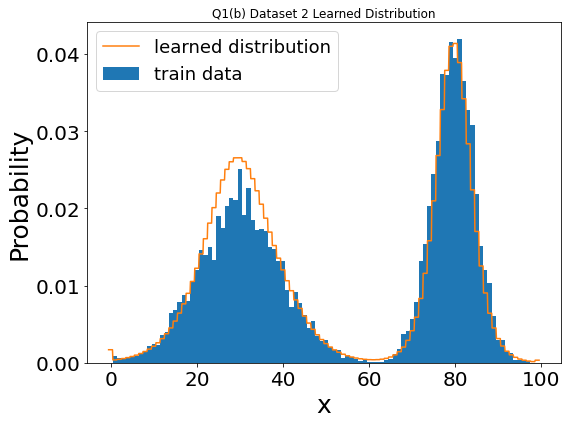

In [24]:
pr1_save_results(2, 'b', pr1_b)

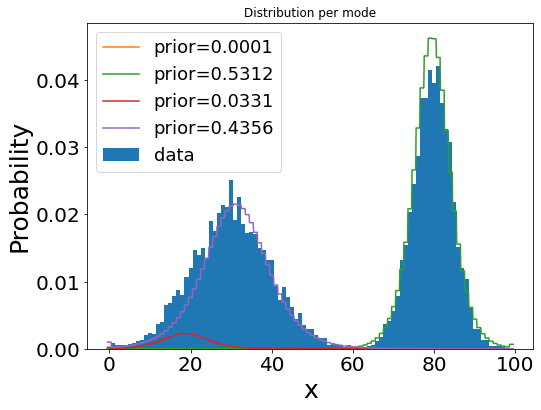

In [25]:
plot_distribution(HistogramB, 4)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

In [7]:
from dul_2021.utils.hw1_utils import *

Dataset 1


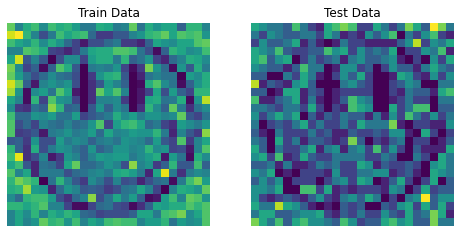

Dataset 2


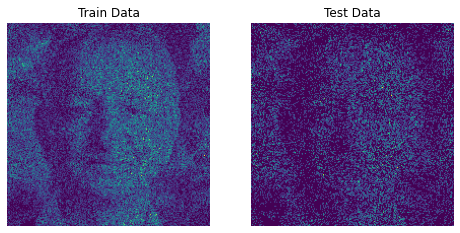

In [14]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

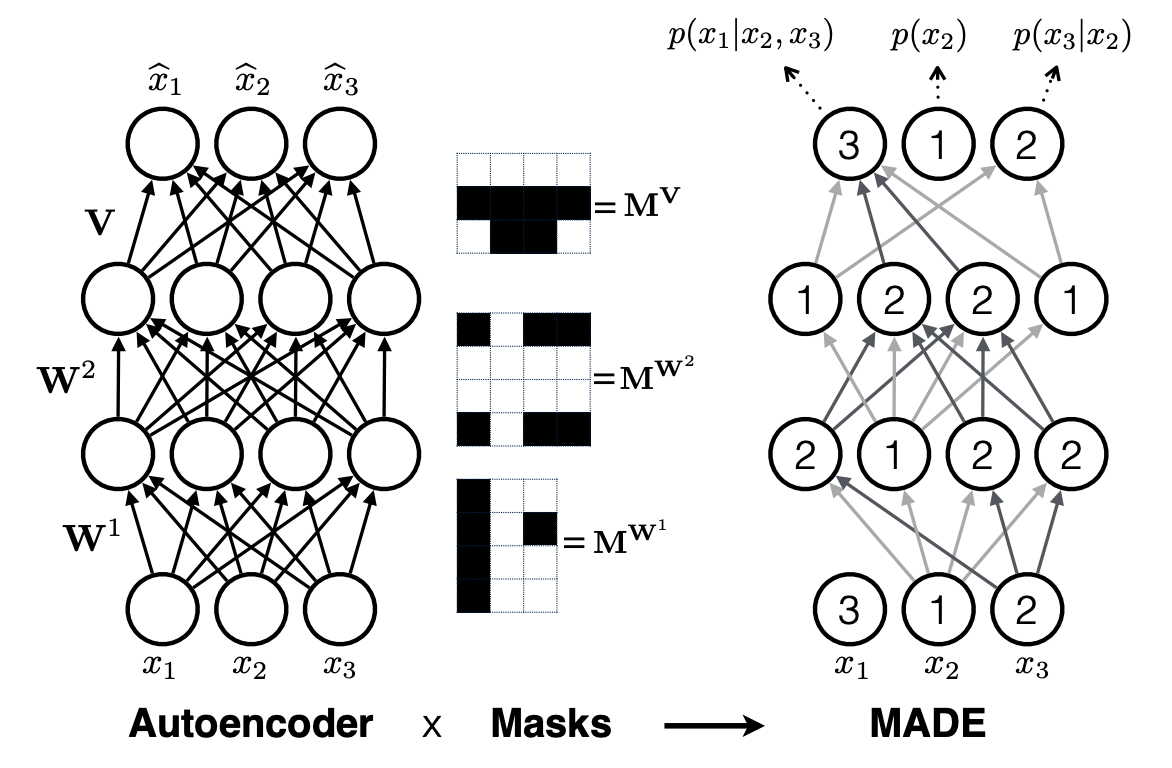

In [ ]:
class MADE(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = {}
        # some init

    def make_masks(self):
        # L = num of hidden layers
        # nin = input dim
        # d = number of values per dim
                
        self.m[-1] = np.arange(nin) # or some other odering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l-1].min(), self.nin-1, size=hidden_size[l])
        
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        masks[-1] = np.repeat(masks[-1], d, axis=1)
        
        # set mask for each masked Linear layer

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        # copy mask
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
        
        # self.weight = self.weight * self.mask
        # return super().forward(input)